In [ ]:
# %%
# Importamos las bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm



# Configuramos el estilo para las visualizaciones
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

# Cargamos el dataset.
try:
    df = pd.read_csv('../resources/full_grouped.csv')
except FileNotFoundError:
    print("El archivo 'full_grouped.csv' no se encontró. Asegúrate de tenerlo en la misma carpeta.")

# Convertimos la columna 'Date' a formato datetime y la establecemos como índice.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Creamos una serie de tiempo global de casos nuevos para el análisis
df_global_new_cases = df.groupby('Date')['New cases'].sum()
df_global_cases = df.groupby('Date')['Confirmed'].sum()


### Suavizado (Smoothing) con Medias Móviles

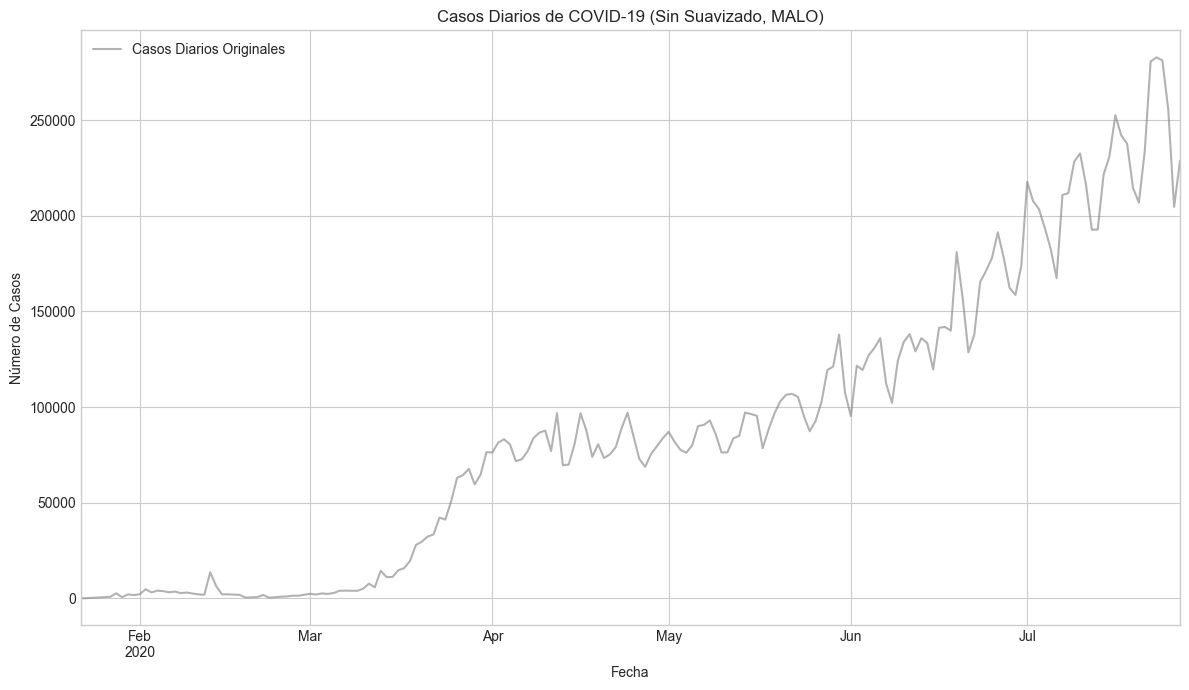

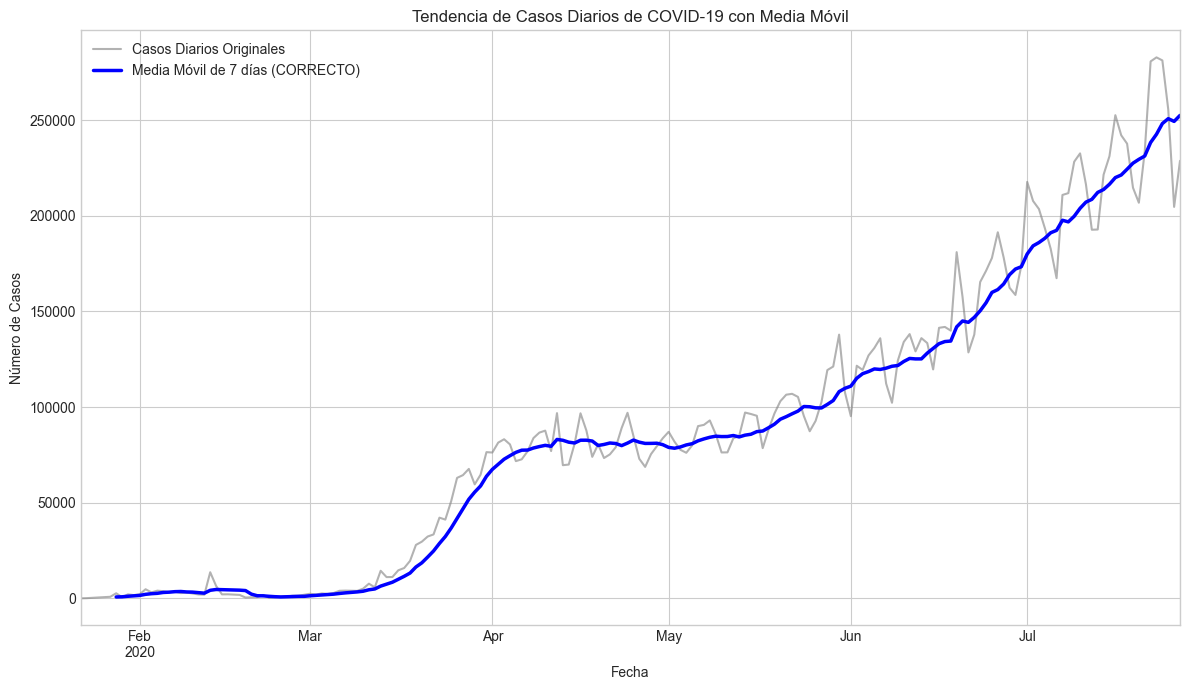

In [6]:
# %%
# Ejemplo INCORRECTO: Gráfico de línea sin suavizar
# El gráfico es "ruidoso" y las fluctuaciones diarias impiden ver la tendencia a largo plazo.
plt.figure(figsize=(12, 7))
df_global_new_cases.plot(label='Casos Diarios Originales', color='gray', alpha=0.6)
plt.title('Casos Diarios de COVID-19 (Sin Suavizado, MALO)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Ejemplo CORRECTO: Gráfico de línea con media móvil suavizada
# Calculamos una media móvil de 7 días (como se discute en el texto).
rolling_mean_7d = df_global_new_cases.rolling(window=7).mean()

plt.figure(figsize=(12, 7))
# Graficamos los datos brutos con menor opacidad
df_global_new_cases.plot(label='Casos Diarios Originales', color='gray', alpha=0.6)
# Graficamos la media móvil para mostrar la tendencia clara
rolling_mean_7d.plot(label='Media Móvil de 7 días (CORRECTO)', color='blue', linewidth=2.5)
plt.title('Tendencia de Casos Diarios de COVID-19 con Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.tight_layout()
plt.show()

### Comparacion de suavizados (LOESS vs. Media Movil)

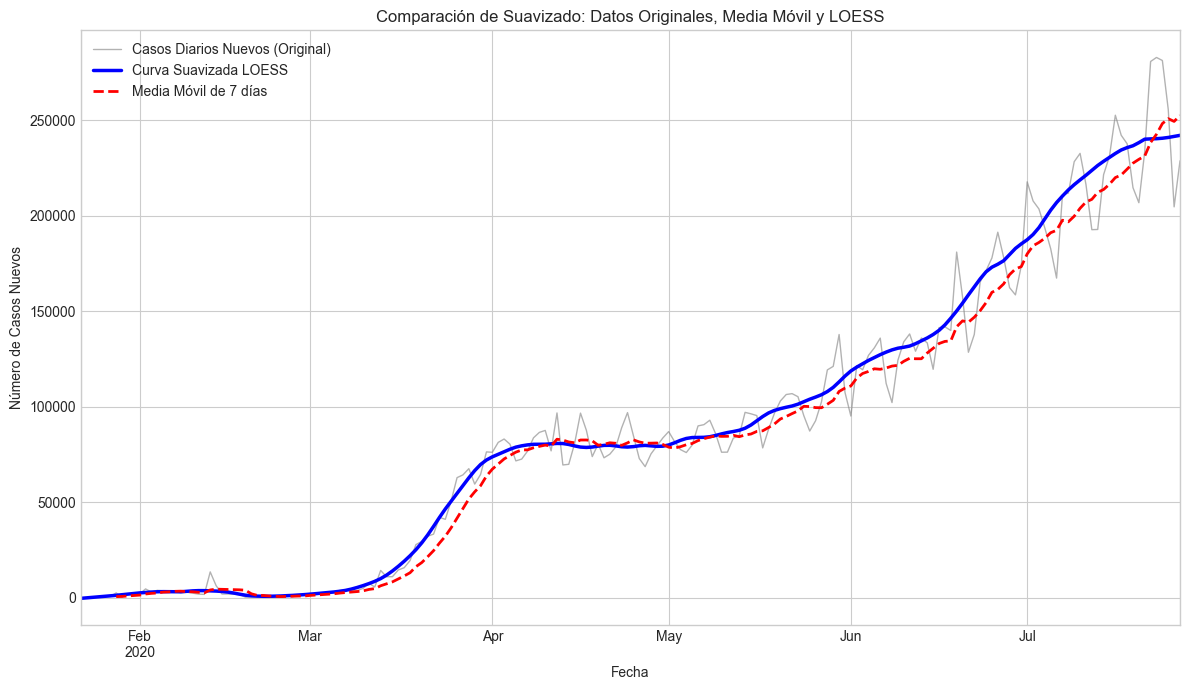

In [7]:
# Calculamos una media móvil de 7 días para comparación
rolling_mean_7d = df_global_new_cases.rolling(window=7).mean()

# Preparamos los datos para la función lowess
# La función requiere una lista de valores Y y una lista de valores X.
y_data = df_global_new_cases.values
x_data = np.arange(len(y_data))

# Aplicamos el suavizado LOESS
# 'frac' es un parámetro clave que controla la suavidad del ajuste (similar a la ventana en la media móvil).
# Un valor más pequeño produce una curva más "pegada" a los datos, y uno más grande, una más suave.
loess_smoothed = sm.nonparametric.lowess(y_data, x_data, frac=0.08)

# El resultado es un array numpy con la línea suavizada. Lo convertimos a una Serie de pandas.
loess_series = pd.Series(loess_smoothed[:, 1], index=df_global_new_cases.index)

# Creamos un gráfico para comparar la serie de tiempo original con la suavizada por LOESS.
plt.figure(figsize=(12, 7))

# Graficamos los datos brutos de forma semi-transparente
df_global_new_cases.plot(label='Casos Diarios Nuevos (Original)', color='gray', alpha=0.6, linewidth=1)

# Graficamos la curva LOESS suavizada
loess_series.plot(label='Curva Suavizada LOESS', color='blue', linewidth=2.5)

# Graficamos la media móvil, que muestra el suavizado más simple y sigue más de cerca las fluctuaciones
rolling_mean_7d.plot(label='Media Móvil de 7 días', color='red', linestyle='--', linewidth=2)


# Añadimos título, etiquetas y leyenda
plt.title('Comparación de Suavizado: Datos Originales, Media Móvil y LOESS')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos Nuevos')
plt.legend()
plt.tight_layout()
plt.show()

### Configuración y Cálculo de los Splines

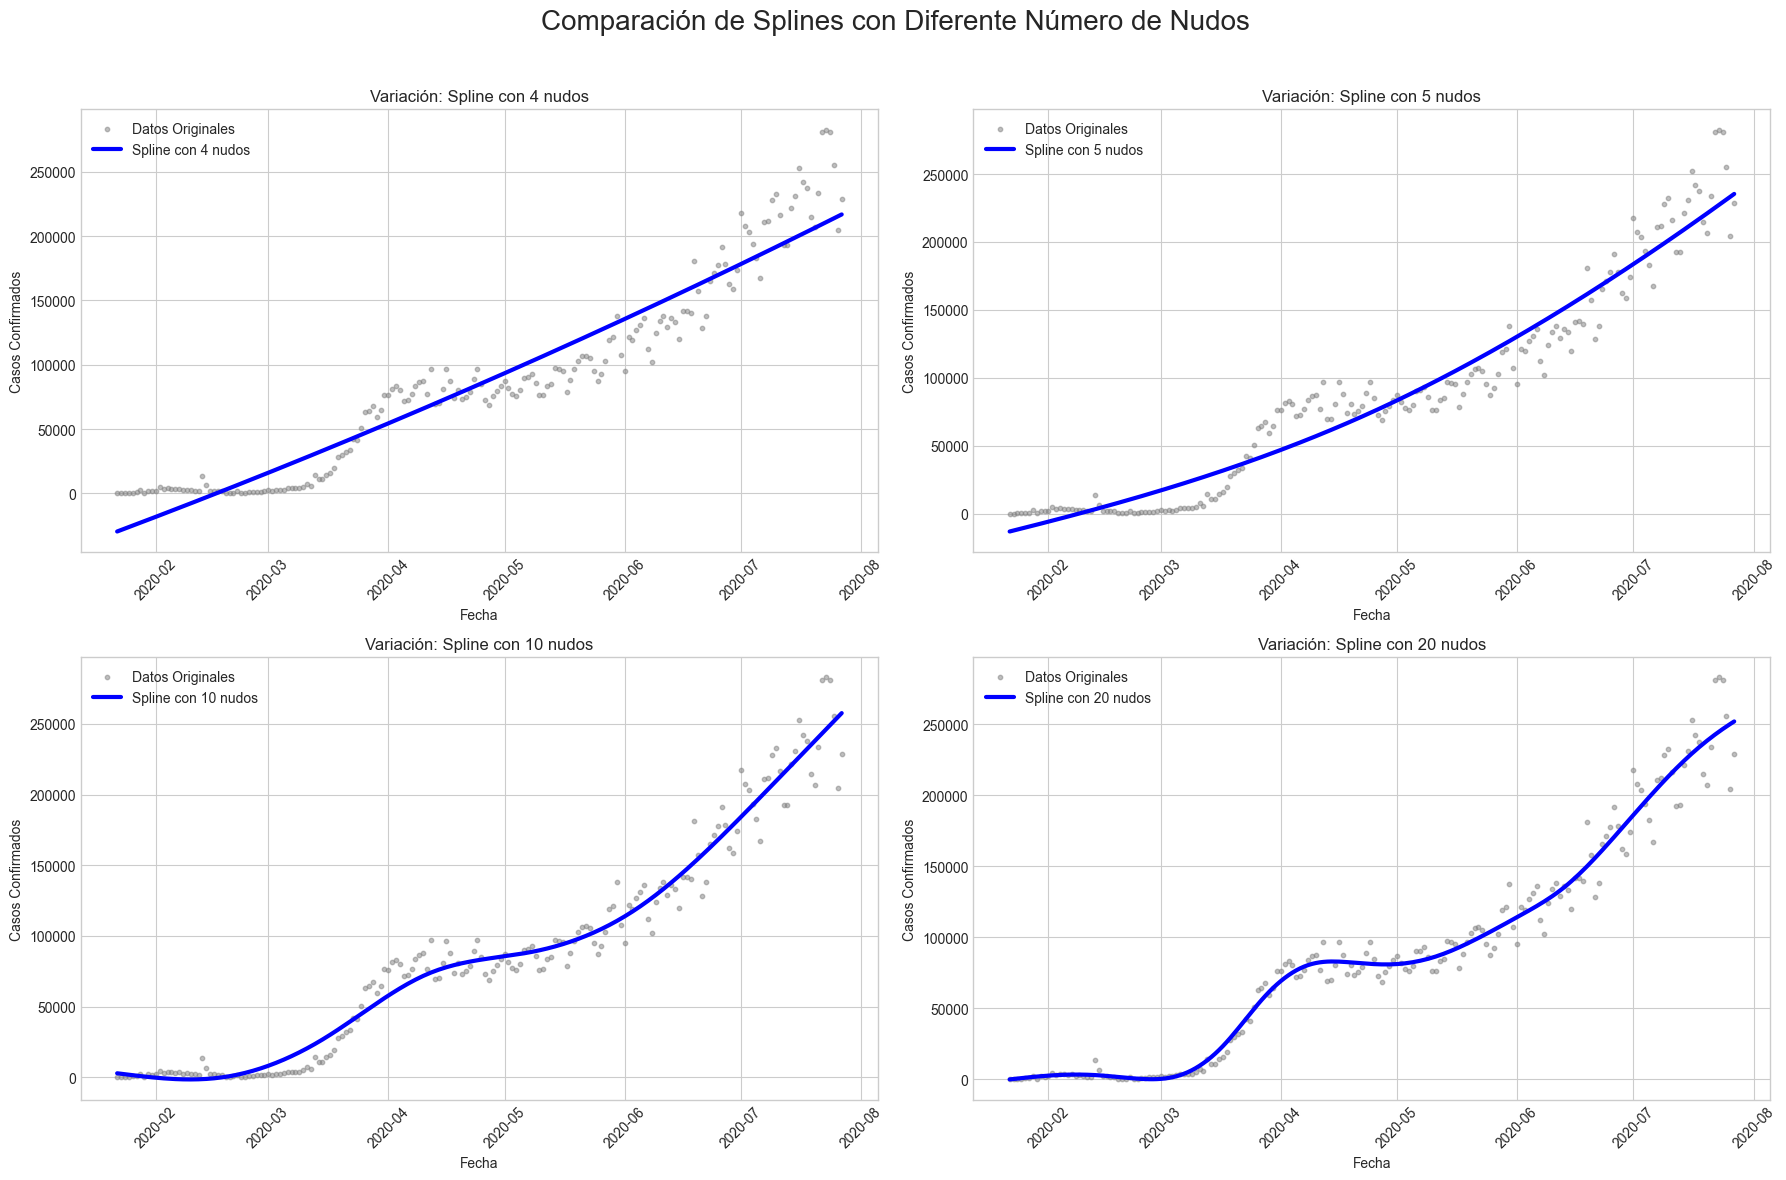

In [8]:
from pygam import LinearGAM, s

x = np.arange(len(df_global_new_cases)).reshape(-1, 1)
y = df_global_new_cases.values

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

titles = ['Spline con 4 nudos', 'Spline con 5 nudos', 'Spline con 10 nudos', 'Spline con 20 nudos']
knots = [4, 5, 10, 20]

for i, k in enumerate(knots):
    gam = LinearGAM(s(0, n_splines=k)).fit(x, y)
    spline_fit = gam.predict(x)
    
    ax = axes[i]
    ax.scatter(df_global_new_cases.index, y, color='gray', alpha=0.5, s=10, label='Datos Originales')
    ax.plot(df_global_new_cases.index, spline_fit, color='blue', linewidth=3, label=f'Spline con {k} nudos')
    ax.set_title(f'Variación: {titles[i]}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Casos Confirmados')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.suptitle('Comparación de Splines con Diferente Número de Nudos', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Grafico de Tendencia (Relacion Funcional)

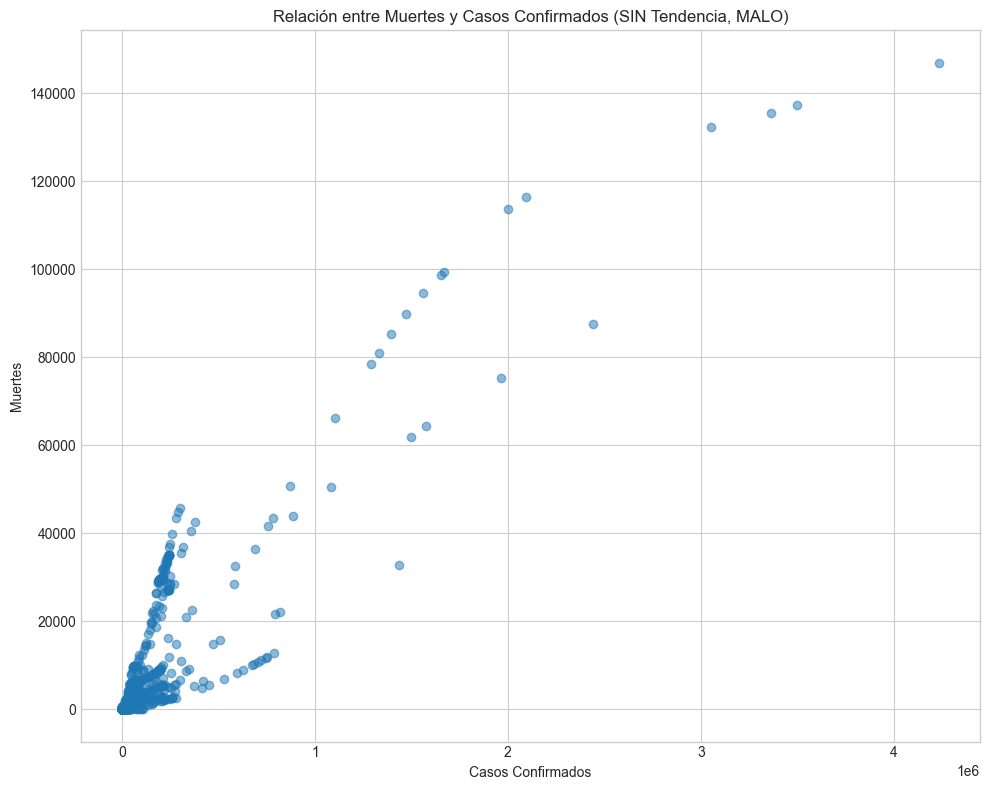

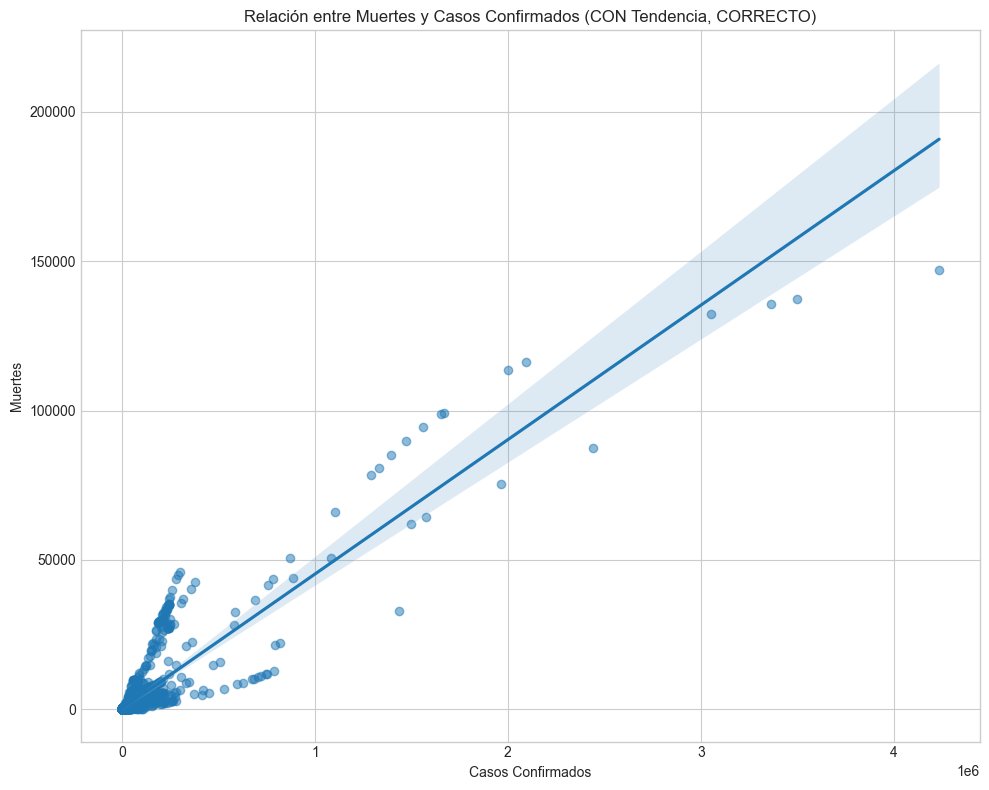

In [9]:
# %%
# Ejemplo INCORRECTO: Gráfico de dispersión sin línea de tendencia
# Es difícil para el ojo humano percibir la relación lineal solo con los puntos.
# Tomamos una muestra aleatoria para evitar sobrecargar el gráfico.
df_sample = df.sample(n=5000, random_state=42)

plt.figure(figsize=(10, 8))
plt.scatter(df_sample['Confirmed'], df_sample['Deaths'], alpha=0.5)
plt.title('Relación entre Muertes y Casos Confirmados (SIN Tendencia, MALO)')
plt.xlabel('Casos Confirmados')
plt.ylabel('Muertes')
plt.tight_layout()
plt.show()

# %%
# Ejemplo CORRECTO: Gráfico de dispersión con línea de tendencia lineal
# Usamos seaborn, que puede dibujar una línea de regresión de forma nativa.
plt.figure(figsize=(10, 8))
sns.regplot(x='Confirmed', y='Deaths', data=df_sample, scatter_kws={'alpha': 0.5})
plt.title('Relación entre Muertes y Casos Confirmados (CON Tendencia, CORRECTO)')
plt.xlabel('Casos Confirmados')
plt.ylabel('Muertes')
plt.tight_layout()
plt.show()

### Gráfico Comparativo: Ajuste Exponencial vs. Ajuste Log-Lineal, frecuencia mensual

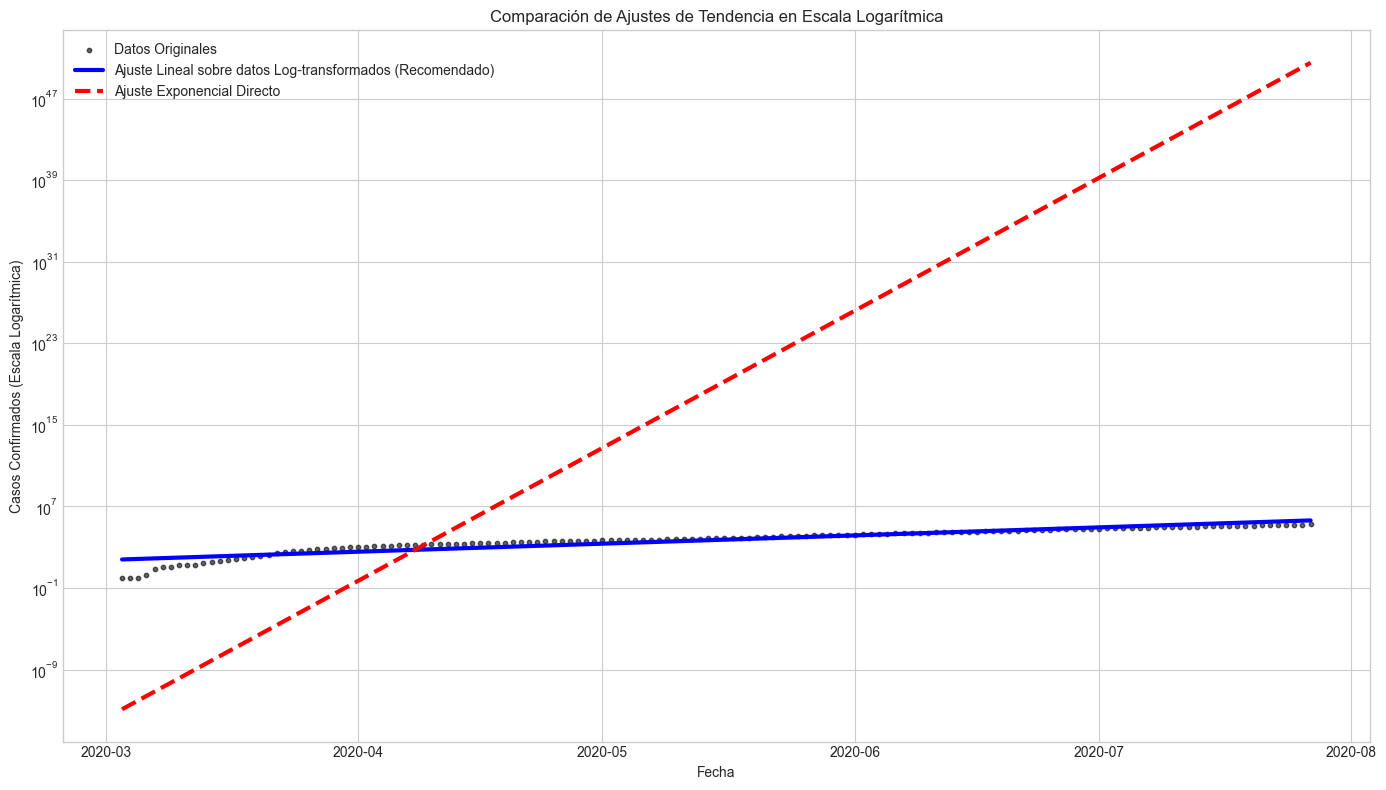

In [10]:
from scipy.optimize import curve_fit
# Filtramos solo Argentina
df_arg = df[df['Country/Region'] == 'Argentina']

# Serie de tiempo de casos confirmados diarios en Argentina
df_arg_cases = df_arg.groupby(df_arg.index)['Confirmed'].sum()

# Filtramos los valores cero para evitar errores con el logaritmo
df_global_cases = df_arg_cases[df_arg_cases > 0]

# Creamos un índice numérico 'x' que representa el número de días desde el inicio
x_data = np.arange(len(df_global_cases))
y_data = df_global_cases.values

# --- 2. Ajuste Exponencial Directo ---
# Definimos la función exponencial para el ajuste
def exponential_func(x, A, m):
    return A * np.exp(m * x)

# Realizamos el ajuste de la curva para encontrar los parámetros óptimos
popt_exp, pcov_exp = curve_fit(exponential_func, x_data, y_data)
A_exp, m_exp = popt_exp
y_fit_exp = exponential_func(x_data, A_exp, m_exp)

# --- 3. Ajuste Lineal sobre datos Log-transformados ---
# Transformamos los datos 'y' a escala logarítmica
log_y_data = np.log(y_data)
# Añadimos una constante a la matriz de diseño para el intercepto
X = sm.add_constant(x_data)
# Ajustamos el modelo de regresión lineal
model = sm.OLS(log_y_data, X)
results = model.fit()

# Obtenemos los parámetros del modelo y los usamos para generar la curva
log_A_fit = results.params[0]
m_fit = results.params[1]
y_fit_log_exp = np.exp(log_A_fit + m_fit * x_data)

# --- 4. Generación del Gráfico Comparativo ---
plt.figure(figsize=(14, 8))

# Graficamos los datos originales con el eje y en escala logarítmica
plt.scatter(df_global_cases.index, y_data, color='black', alpha=0.6, label='Datos Originales', s=10)
plt.yscale('log')

# Trazamos el ajuste lineal sobre datos log-transformados
plt.plot(df_global_cases.index, y_fit_log_exp, color='blue', linewidth=3, label='Ajuste Lineal sobre datos Log-transformados (Recomendado)')

# Trazamos el ajuste exponencial directo
plt.plot(df_global_cases.index, y_fit_exp, color='red', linestyle='--', linewidth=3, label='Ajuste Exponencial Directo')

plt.title('Comparación de Ajustes de Tendencia en Escala Logarítmica')
plt.xlabel('Fecha')
plt.ylabel('Casos Confirmados (Escala Logarítmica)')
plt.legend()
plt.tight_layout()
plt.show()

### Gráfico Comparativo: Ajuste Exponencial vs. Ajuste Log-Lineal, filtrado primeros 60 dias

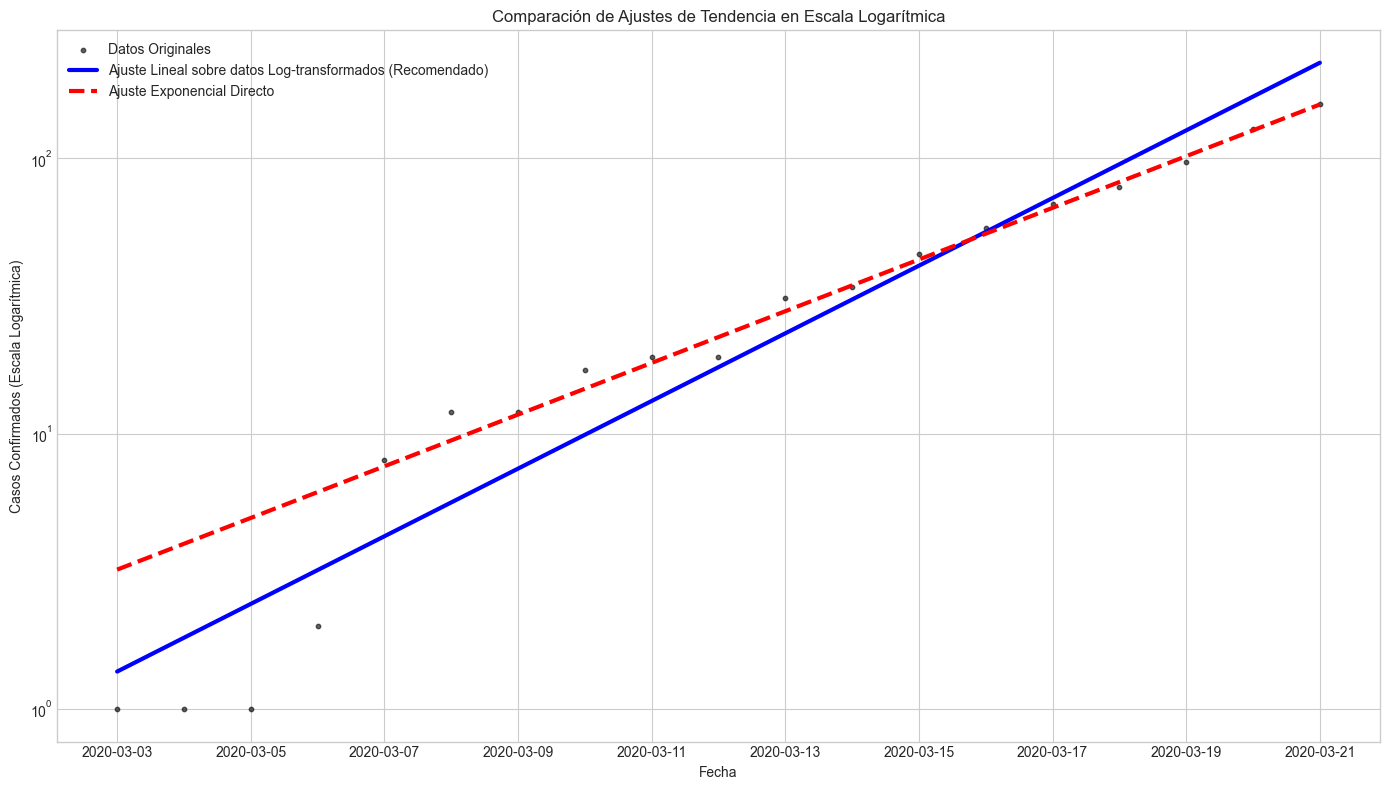

In [11]:
from scipy.optimize import curve_fit
# Filtramos solo Argentina
df_arg = df[df['Country/Region'] == 'Argentina']

# Serie de tiempo de casos confirmados diarios en Argentina
df_arg_cases = df_arg.groupby(df_arg.index)['Confirmed'].sum()
# Filtramos los primeros 60 días
df_60dias = df_arg_cases.iloc[:60]
# Filtramos los valores cero para evitar errores con el logaritmo
df_global_cases = df_60dias[df_60dias > 0]

# Creamos un índice numérico 'x' que representa el número de días desde el inicio
x_data = np.arange(len(df_global_cases))
y_data = df_global_cases.values

# --- 2. Ajuste Exponencial Directo ---
# Definimos la función exponencial para el ajuste
def exponential_func(x, A, m):
    return A * np.exp(m * x)

# Realizamos el ajuste de la curva para encontrar los parámetros óptimos
popt_exp, pcov_exp = curve_fit(exponential_func, x_data, y_data)
A_exp, m_exp = popt_exp
y_fit_exp = exponential_func(x_data, A_exp, m_exp)

# --- 3. Ajuste Lineal sobre datos Log-transformados ---
# Transformamos los datos 'y' a escala logarítmica
log_y_data = np.log(y_data)
# Añadimos una constante a la matriz de diseño para el intercepto
X = sm.add_constant(x_data)
# Ajustamos el modelo de regresión lineal
model = sm.OLS(log_y_data, X)
results = model.fit()

# Obtenemos los parámetros del modelo y los usamos para generar la curva
log_A_fit = results.params[0]
m_fit = results.params[1]
y_fit_log_exp = np.exp(log_A_fit + m_fit * x_data)

# --- 4. Generación del Gráfico Comparativo ---
plt.figure(figsize=(14, 8))

# Graficamos los datos originales con el eje y en escala logarítmica
plt.scatter(df_global_cases.index, y_data, color='black', alpha=0.6, label='Datos Originales', s=10)
plt.yscale('log')

# Trazamos el ajuste lineal sobre datos log-transformados
plt.plot(df_global_cases.index, y_fit_log_exp, color='blue', linewidth=3, label='Ajuste Lineal sobre datos Log-transformados (Recomendado)')

# Trazamos el ajuste exponencial directo
plt.plot(df_global_cases.index, y_fit_exp, color='red', linestyle='--', linewidth=3, label='Ajuste Exponencial Directo')

plt.title('Comparación de Ajustes de Tendencia en Escala Logarítmica')
plt.xlabel('Fecha')
plt.ylabel('Casos Confirmados (Escala Logarítmica)')
plt.legend()
plt.tight_layout()
plt.show()

### Eliminacion de la tendencia (detrending)

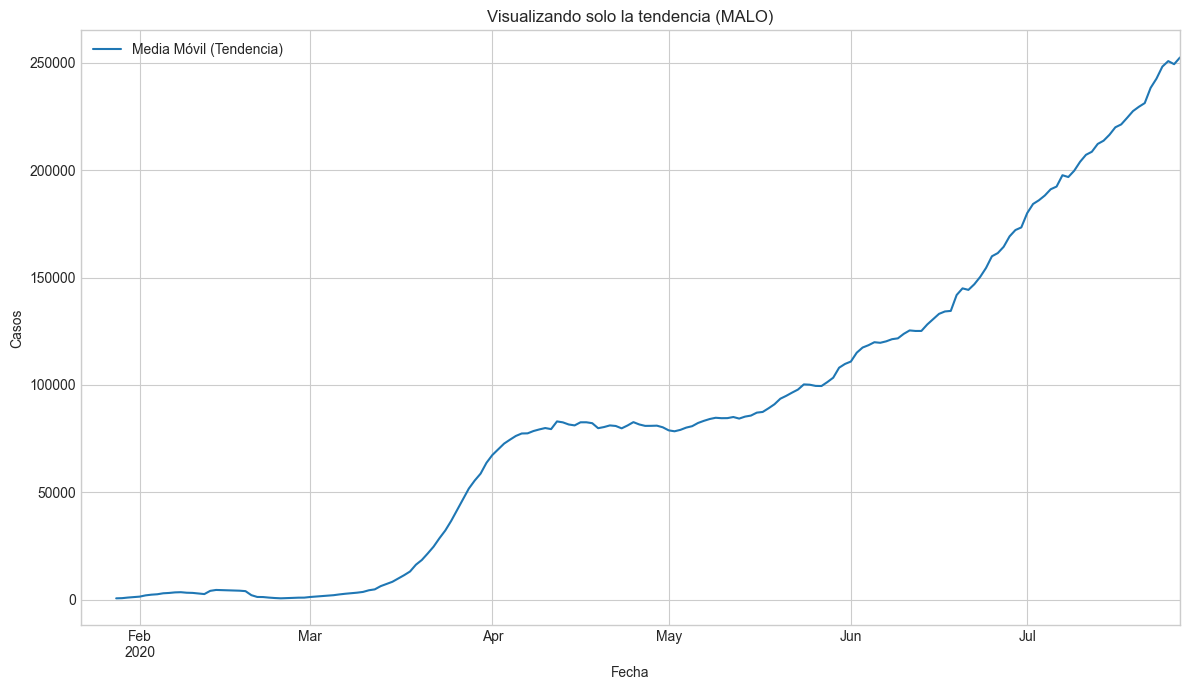

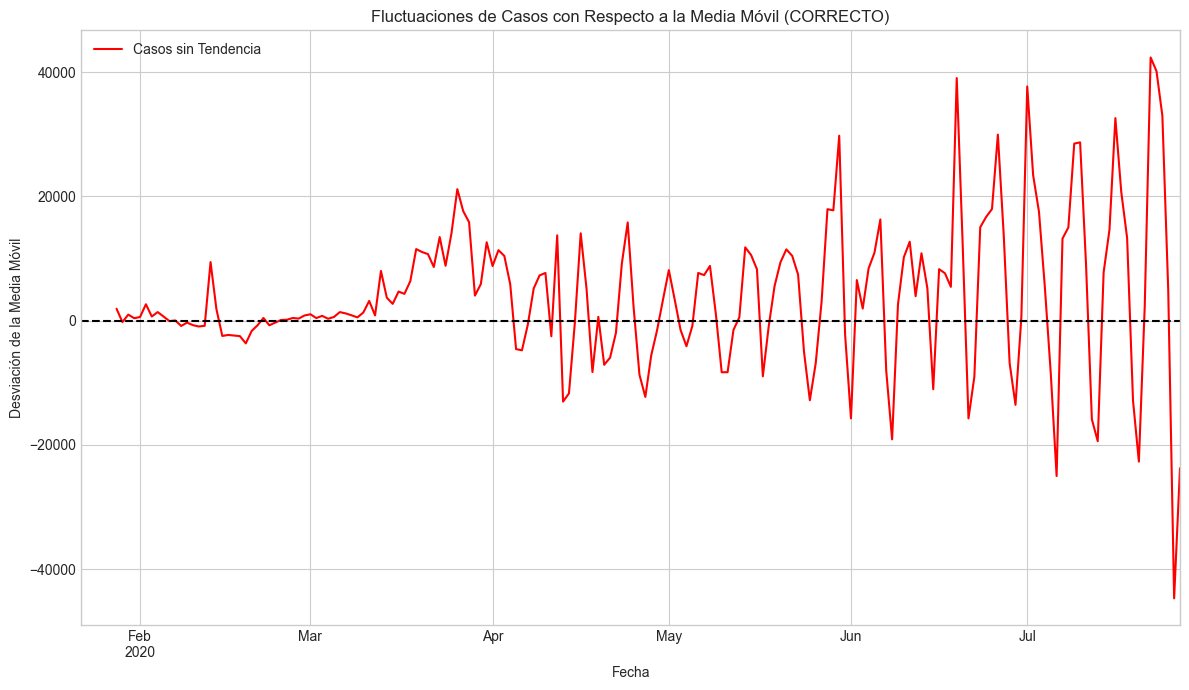

In [12]:
# %%
# Ejemplo INCORRECTO: Gráfico de línea de la tendencia original
# Este gráfico solo muestra la media móvil, que es la tendencia, pero no las desviaciones.
plt.figure(figsize=(12, 7))
rolling_mean_7d.plot(label='Media Móvil (Tendencia)')
plt.title('Visualizando solo la tendencia (MALO)')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Ejemplo CORRECTO: Gráfico de la serie de tiempo sin la tendencia
# Restamos la media móvil a los datos brutos para obtener las desviaciones.
detrended_data = df_global_new_cases - rolling_mean_7d

plt.figure(figsize=(12, 7))
detrended_data.plot(label='Casos sin Tendencia', color='red')
plt.axhline(y=0, color='black', linestyle='--') # Línea de referencia en cero
plt.title('Fluctuaciones de Casos con Respecto a la Media Móvil (CORRECTO)')
plt.xlabel('Fecha')
plt.ylabel('Desviación de la Media Móvil')
plt.legend()
plt.tight_layout()
plt.show()